# ABUNDANCES DERIVATIONS WITH THE DIRECT METHOD

## The chemical composition of IC 2165

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyneb as pn
from pyneb.utils.physics import IP
from pyneb.utils.misc import parseAtom
pn.log_.level=1


### ??? Using the plasma diagnostics diagram for IC 2165 estimate the following parameters: ne([O II]), ne([Ar IV]), Te([N II]), Te([O III]) from the optical data only.

##### We use the following values.

In [2]:
# Fill the following with values determined in the previous section
Ne_O2 = 10**3.6
Ne_Ar4 = 10**3.4
T_N2 = 13500.
T_O3 = 14000. 

### ??? Determine the ionic abundances for N, O, Ne ions. 

### ??? Justify your choice of temperature and density to compute line emissivities.

##### We define a function to read the observations.

In [3]:
def get_data(name, opt_only=True):
    """
    Return a PyNeb Observation object containing the observed line intensities
    keywords:
        - name: name of the observation file (.dat will be added)
        - opt_only [True]: if True, only optical data is read, otherwise
            IR and UV data are read, with cross-calibration made
            using HI 5-4 / Hbeta line ratio
    """
    obs = pn.Observation()
    obs.readData(name+'.dat', fileFormat='lines_in_rows', 
                 corrected=True)
    if opt_only:
        return obs
    obs.readData(name+'_UV.dat', fileFormat='lines_in_rows', 
                 corrected=True)
    obs_ir = pn.Observation(name+'_IR.dat', fileFormat='lines_in_rows', 
                            corrected=True)
    H1r = pn.RecAtom('H', 1)
    H1_54_b_th = H1r.getEmissivity(T_N2, Ne_O2, 5, 4) / \
                 H1r.getEmissivity(T_N2, Ne_O2, 4, 2)
    coeff_norm = H1_54_b_th / obs_ir.getIntens()['H1r_4.1m'] * 100
    for line in obs_ir.lines:
        line.corrIntens *= coeff_norm
        obs.addLine(line)
    return obs

##### We define a function to compute the ionic abundances.

In [7]:
print(IP['O3'], IP['Ar4'])

35.12 40.74


In [18]:
def getIonAb(obs_name, Ne_O2, Ne_Ar4, T_N2, T_O3, printIonAb = True,
             opt_only=True):
    """
    Return a dictionary of ionic abundances.
    Keywords:
        - obs_name: file name of the observed line intensities
        - Ne_O2, Ne_Ar4, T_N2, T_O3: electron densities and temperatures
            to be used.
        - printIonAb [True]: if set, the abundances obtained for each line
            and for each ion are printed out
    """
    # define an Observation object and assign it to name 'obs'
    obs = get_data(obs_name, opt_only=opt_only)
    # instantiation of all the needed Atom objects. We use only 10 levels for the Mg4 atom
    all_atoms = pn.getAtomDict(atom_list=obs.getUniqueAtoms(), NLevels=10)
    
    # define a dictionary for the ionic abundances
    ab_dic = {}
    # we  use the following lines to determine the ionic abundances
    ab_labels = ['N2_6584A', 'N3_57.4m', 'N4_1487A', 
                 'O2_3726A', 'O2_3729A', 'O3_5007A', 'O4_25.9m',
                 'Ne2_12.8m', 'Ne3_3869A', 'Ne5_3426A', 'Ne6_7.6m']
    # loop on the observed lines to determine the corresponding ionic abundances
    for line in obs.getSortedLines():
        # this is one way to define temp and dens in each zone
        # must be adapted to each case
        if (line.atom in all_atoms) and (line.label in ab_labels):
            IP_cut = 30. # The IPs have been imported before
            if IP[line.atom] > IP_cut:
                temp = T_O3
                dens = Ne_Ar4
                IP_used = 'H'
            else:
                temp = T_N2
                dens = Ne_O2
                IP_used = 'L'                 
            ab = all_atoms[line.atom].getIonAbundance(line.corrIntens, temp, dens, 
                                                      to_eval=line.to_eval, 
                                                      Hbeta=100)
            if printIonAb:
                print('{0:13s} {1} '.format(line.label, IP_used) + 
                      ' '.join(['{0:>8.4f}'.format(t) for t in ab * 1e6]))
            if line.atom not in ab_dic:
                ab_dic[line.atom] = []
            ab_dic[line.atom].append(ab)
    
    He1r = pn.RecAtom('He', 1)
    He2r = pn.RecAtom('He', 2)
    ab_dic['He1r']= He1r.getIonAbundance(obs.getLine(label='He1r_5876A').corrIntens, 
                                 T_N2, Ne_O2, wave=5876.0)
    ab_dic['He2r'] = He2r.getIonAbundance(obs.getLine(label='He2r_4686A').corrIntens, 
                                 T_O3, Ne_Ar4, lev_i= 4, lev_j= 3)
    # Compute the mean of abundances when multiple lines 
    # from the same ions are used
    for atom in ab_dic:
        mean = np.mean(np.asarray(ab_dic[atom]))
        ab_dic[atom] = mean
    
    if printIonAb:
        for ion in np.sort(list(ab_dic.keys())):
            print('12 + log({0:3s}) = {1:5.2f}'.format(ion, np.log10(ab_dic[ion])+12))

    return ab_dic

In [19]:
ion_ab_dic = getIonAb('../Data/IC2165', Ne_O2, Ne_Ar4, T_N2, T_O3, 
                      printIonAb = True, opt_only=True)

N2_6584A      L   1.7999
Ne3_3869A     H  28.1808
Ne5_3426A     H  18.0773
O2_3726A      L   5.3998
O2_3729A      L   4.8904
O3_5007A      H 146.6095
12 + log(He1r) = 10.63
12 + log(He2r) = 10.74
12 + log(N2 ) =  6.26
12 + log(Ne3) =  7.45
12 + log(Ne5) =  7.26
12 + log(O2 ) =  6.71
12 + log(O3 ) =  8.17


###  ??? Comment on the abundances of the same ion as determined by different lines.

### ??? Determine the abundances of N, O, Ne from the optical data only using the ionization correction factors from Delgado-Inglada et al (2014).

##### We define a function to determine the elemental abundances.

In [20]:
def getElemAb(ab_dic, icf_family=None, printRule = True):
    """
    Return the elemental abundances, using the PyNeb ICF object.
    Parameters:
        - ab_dic: a dictionary containing the ionic abundances
        - icf_family [None]: an ICF family (e. g. "KB94")
        - printRule [True]: if set, the rules used to determine the 
            abundances are printed out
    """
    # Instantiation of the ICF object
    icf = pn.ICF()
    # Computing the elemental abundances from all ICF rules.
    
    # The following computes the elemental abundances from the rules.
    elem_abun = icf.getElemAbundance(ab_dic, icf_family=icf_family)
    
    for icf_ref in np.sort(list(elem_abun.keys())):
        if np.isfinite(elem_abun[icf_ref]) and np.log10(elem_abun[icf_ref]).all() > -10:
            if printRule:
                print('{0} {1}={3:.3} using {2}'.format(icf_ref, 
                                                  icf.all_icfs[icf_ref]['elem'],
                                                  icf.getExpression(icf_ref), 
                                                  np.log10(elem_abun[icf_ref])+12))
            else:
                print('{0:12s} {1}={2:.3}'.format(icf_ref, 
                                                  icf.all_icfs[icf_ref]['elem'],
                                                  np.log10(elem_abun[icf_ref])+12))
                

    return elem_abun

In [23]:
elem_abun = getElemAb(ion_ab_dic, 'DIMS14', printRule = True)

DIMS14_10 He=11.0 using He = (He2 + He3) * 1.0
DIMS14_12 O=8.43 using O = (O2 + O3) * 10**((0.08 * He3 / (He2 + He3) + 0.006 * (He3 / (He2 + He3))**2) / (0.34 - 0.27 * He3 / (He2 + He3)))
DIMS14_14 N=7.86 using N = (N2) * 10**(-0.16 * O3 / (O2 + O3) * (1.0 + np.log10(He3 / (He2 + He3)))) * DIMS14_12 / O2
DIMS14_14b N=8.59 using N = (N2) * 10**(0.64 * O3 / (O2 + O3)) * DIMS14_12 / O2
DIMS14_17a Ne=7.71 using Ne = (Ne3) * (O3 / (O2 + O3) + (0.014 / (He3 / (He2 + He3)) + 2 * (He3 / (He2 + He3))**2.7)**3 * (0.7 + 0.2 * O3 / (O2 + O3) - 0.8 * (O3 / (O2 + O3))**2)) * DIMS14_12 / O3
DIMS14_17b Ne=7.85 using Ne = (Ne3) * (O3 / (O2 + O3) + (0.014 / (0.01) + 2 * (0.01)**2.7)**3 * (0.7 + 0.2 * O3 / (O2 + O3) - 0.8 * (O3 / (O2 + O3))**2)) * DIMS14_12 / O3
DIMS14_17c Ne=7.75 using Ne = (Ne3) * (O3 / (O2 + O3) + (0.014 / (0.015) + 2 * (0.015)**2.7)**3 * (0.7 + 0.2 * O3 / (O2 + O3) - 0.8 * (O3 / (O2 + O3))**2)) * DIMS14_12 / O3
DIMS14_20 Ne=7.83 using Ne = (Ne3+Ne5) * (1.31+12.68*(He3/(He2+He3))**2.5

In [24]:
elem_abun = getElemAb(ion_ab_dic, 'KB94', printRule = True)

KB94_A1.10 N=7.96 using N = (N2) * KB94_A10  / O2
KB94_A10 O=8.42 using O = (O2 + O3) * ((He2 + He3) / He2)**(2./3.)
KB94_A10b O=8.18 using O = O2 + O3
KB94_A27 Ne=7.84 using Ne = (Ne3 + Ne5) * 1.5
KB94_A28.10 Ne=7.7 using Ne = (Ne3) * KB94_A10  / O3
KB94_A28.10b Ne=7.46 using Ne = (Ne3) * KB94_A10b  / O3


In [25]:
# By hand, using the tables of emissivities:
I_obs_O2_3726A = 18.39 
I_obs_O2_3729A = 9.36
I_obs_O3_5007A = 1158.31
I_obs_He1r_5876A = 7.24
I_obs_He2r_4686A = 63.48
I_obs_Hb = 100
emiss_O2_3726A = 1.87e-21
emiss_O2_3729A = 4.77e-21
emiss_Hb = 9.23e-26 
emiss_O3_5007A = 7.05e-21
emiss_He1r_5876A = 1.27e-25
emiss_He2r_4686A = 1.07e-24

O2_1 = (I_obs_O2_3726A / emiss_O2_3726A) / (I_obs_Hb / emiss_Hb)
O2_2 = (I_obs_O2_3729A / emiss_O2_3729A) / (I_obs_Hb / emiss_Hb)
O2 = (O2_1 + O2_2) / 2
O2_bis =  ((I_obs_O2_3726A+I_obs_O2_3729A) / (emiss_O2_3726A+emiss_O2_3729A))/ (I_obs_Hb / emiss_Hb)
O3 = (I_obs_O3_5007A / emiss_O3_5007A) / (I_obs_Hb / emiss_Hb)
He2 = (I_obs_He1r_5876A / emiss_He1r_5876A) / (I_obs_Hb / emiss_Hb)
He3 = (I_obs_He2r_4686A / emiss_He2r_4686A) / (I_obs_Hb / emiss_Hb)

OoH = (O2 + O3)*10**((0.08 * He3 / (He2 + He3) + 0.006 * (He3 / (He2 + He3))**2) / (0.34 - 0.27 * He3 / (He2 + He3)))
print('O+/H+={:.1f} ppm, O+/H+={:.1f} ppm, O++/H+={:.1f} ppm, 12 + log O/H={:.2f}'.format(O2*1e6, O2_bis*1e6, O3*1e6, 12+np.log10(OoH)))

O+/H+=5.4 ppm, O+/H+=3.9 ppm, O++/H+=151.6 ppm, 12 + log O/H=8.41


### Compute the error bars on the element abundances assigning reasonable uncertainties to the measured line intensities and to the effects of cross-calibrations

##### We add errors depending on the intensities and the origin of the observation.

In [35]:
obs = get_data('../Data/IC2165', opt_only=False)
for line in obs.lines:
    error = 0.1 + np.zeros_like(line.corrError)
    if line.corrIntens < 10:
        error += 0.1
    if line.corrIntens < 1:
        error += 0.1
    if line.wave < 2000. or line.wave > 9700.:
        error += 0.1
    line.corrError = error

In [45]:
obs.lineLabels

array(['Ne5_3426A', 'O2_3726A', 'O2_3729A', 'Ne3_3869A', 'S2_4069A',
       'S2_4076A', 'O3_4363A', 'Fe3_4659A', 'He2r_4686A', 'Fe3_4701A',
       'Ar4_4711A', 'Ar4_4740A', 'H1r_4861A', 'O3_4959A', 'O3_5007A',
       'Ar3_5192A', 'N1_5198A', 'N1_5200A', 'Fe2_5272A', 'Cl4_5323A',
       'Cl3_5518A', 'Cl3_5538A', 'O1_5577A', 'N2_5755A', 'He1r_5876A',
       'O1_6300A', 'S3_6312A', 'Ar5_6435A', 'N2_6584A', 'S2_6716A',
       'S2_6731A', 'Ar5_7005A', 'Ar3_7136A', 'Ar4_7170A', 'Ar4_7237A',
       'Ar4_7263A', 'Cl4_7531A', 'O2_7319A+', 'O2_7330A+', 'Ar3_7751A',
       'Cl4_8046A', 'Cl3_8500A', 'S3_9069A', 'N4_1487A', 'Ne5_1575A',
       'O3_1666A', 'N3_1754A', 'C3_1907A', 'C3_1909A', 'H1r_4.1m',
       'Mg4_4.5m', 'Ar6_4.5m', 'Mg5_5.6m', 'Ne6_7.65m', 'Ar5_7.9m',
       'Ar3_9.0m', 'S4_10.5m', 'Ne2_12.8m', 'Ar5_13.1m', 'Mg5_13.5m',
       'Ne5_14.3m', 'Ne3_15.6m', 'S3_18.7m', 'Ne5_24.3m', 'O4_25.9m',
       'S3_33.5m', 'Ne3_36.0m', 'O3_51.8m', 'N3_57.4m', 'O3_88.3m'], 
      dtype='<U10')

##### We generate 2500 "fake" observations around the observed values, using the errors.

In [36]:
N_MC = 2500
pn.config.use_multiprocs()
obs.addMonteCarloObs(N_MC)
obs.correctData()
print(obs.n_obs)
diags = pn.Diagnostics()
diags.addDiagsFromObs(obs)
T_H, dens_H = diags.getCrossTemDen('[OIII] 4363/5007', '[ArIV] 4740/4711', 
                                         obs=obs)
T_L, dens_L = diags.getCrossTemDen('[NII] 5755/6584', '[SII] 6731/6716', 
                                         obs=obs)

2501


/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/pyneb/core/diags.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """ @module
/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/pyneb/core/diags.py:695: RuntimeWarning: invalid value encountered in greater
  no_conv = ((abs(den_old - den) / den * 100) > tol_den) | ((abs(tem_old - tem) / tem * 100) > tol_tem)


##### We change a little the computation of the ionic abundances to take into account the fake Monte Carlo observations

In [30]:
def getIonAb2(obs, Ne_O2, Ne_Ar4, T_N2, T_O3):

    all_atoms = pn.getAtomDict(atom_list=obs.getUniqueAtoms(), NLevels=10)
    
    # define a dictionary for the ionic abundances
    ab_dic = {}
    # we  use the following lines to determine the ionic abundances
    ab_labels = ['N2_6584A', 'N3_57.4m', 'N4_1487A', 
                 'O2_3726A', 'O2_3729A', 'O3_5007A', 'O4_25.9m',
                 'Ne2_12.8m', 'Ne3_3869A', 'Ne5_3426A', 'Ne6_7.6m']
    # loop on the observed lines to determine the corresponding ionic abundances
    for line in obs.getSortedLines():
        # this is one way to define temp and dens in each zone
        # must be adapted to each case
        if (line.atom in all_atoms) and (line.label in ab_labels):
            IP_cut = 30. #
            if IP[line.atom] > IP_cut:
                temp = T_O3
                dens = Ne_Ar4
                IP_used = 'H'
            else:
                temp = T_N2
                dens = Ne_O2
                IP_used = 'L'                 
            ab = all_atoms[line.atom].getIonAbundance(line.corrIntens, temp, dens, 
                                                      to_eval=line.to_eval, 
                                                      Hbeta=100)
            #print(line, ab)
            if line.atom not in ab_dic:
                ab_dic[line.atom] = []
            ab_dic[line.atom].extend(ab)
    
    He1r = pn.RecAtom('He', 1)
    He2r = pn.RecAtom('He', 2)
    ab_dic['He2']= He1r.getIonAbundance(obs.getLine(label='He1r_5876A').corrIntens, 
                                 T_N2, Ne_O2, wave=5876.0)
    ab_dic['He3'] = He2r.getIonAbundance(obs.getLine(label='He2r_4686A').corrIntens, 
                                 T_O3, Ne_Ar4, lev_i= 4, lev_j= 3)
    # Compute the mean of abundances when multiple lines 
    # from the same ions are used
    for atom in ab_dic:
        n_lines = int(len(ab_dic[atom]) / obs.n_obs)
        ab_lines = np.asarray(ab_dic[atom]).reshape(n_lines, obs.n_obs)
        mean = np.mean(ab_lines, axis=0)
        ab_dic[atom] = mean
    
    return ab_dic

In [37]:
ion_ab_dic = getIonAb2(obs, dens_L, dens_H, T_L, T_H)

/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/pyneb/core/pynebcore.py:3240: RuntimeWarning: invalid value encountered in less
  tt = (logd < log_dens_min)
/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/pyneb/core/pynebcore.py:3246: RuntimeWarning: invalid value encountered in greater
  tt = (logd > log_dens_max)


He2: -1.33+0.09-0.11
He3: -1.26+0.04-0.05
N2 : -5.69+0.21-0.17
N3 : -4.58+0.44-0.32
N4 : -4.21+0.20-0.20
Ne2: -5.35+0.12-0.16
Ne3: -4.58+0.09-0.09
Ne5: -4.79+0.10-0.10
O2 : -5.26+0.40-0.28
O3 : -3.86+0.10-0.11
O4 : -4.20+0.20-0.20


/Users/christophemorisset/anaconda/envs/py3k6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


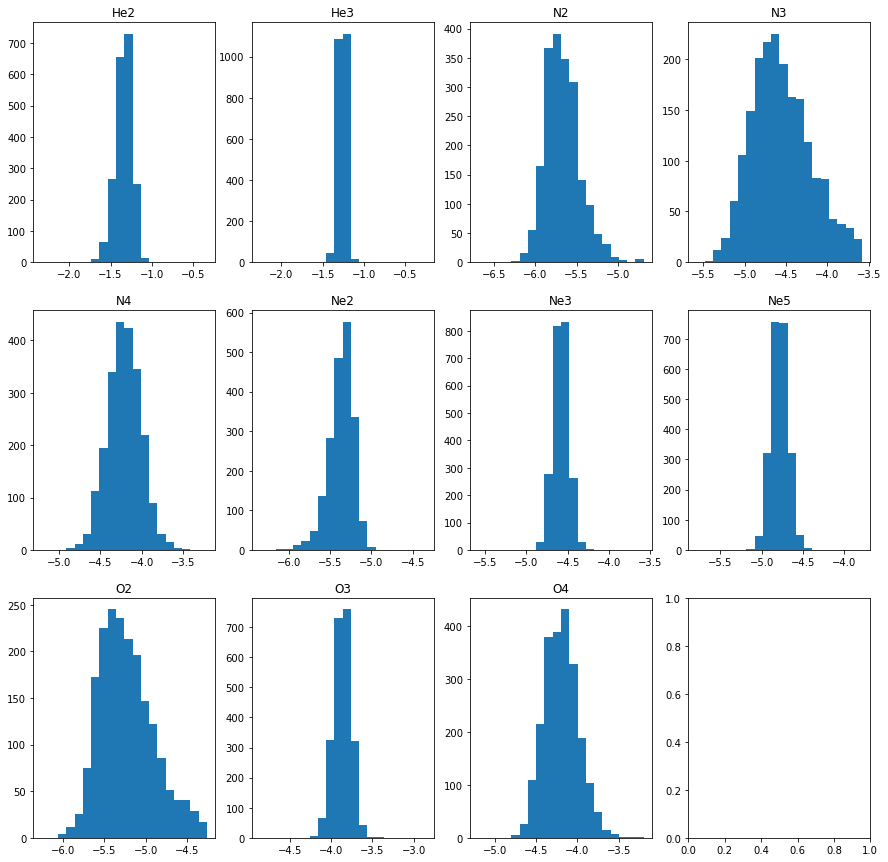

In [38]:
from scipy.stats.mstats import mquantiles

f, axes = plt.subplots(3,4, figsize=(15, 15))
for i, ion in enumerate(sorted(ion_ab_dic.keys())):
    ax = axes.ravel()[i]
    this_ion_ab = np.log10(ion_ab_dic[ion])
    this_ion_ab = this_ion_ab[np.isfinite(this_ion_ab)]
    med = np.median(this_ion_ab)
    try:
        ax.hist(this_ion_ab, range = (med-1., med+1.), bins=20)
        ax.set_title(ion)
        quants = mquantiles(this_ion_ab, [0.16, 0.84])
        error_up = quants[1] - med
        error_down = med - quants[0]
        print('{:3}: {:.2f}+{:.2f}-{:.2f}'.format(ion, med, error_up, error_down))
    except:
        print('ion {} not working'.format(ion))

In [39]:
from pyneb.utils.misc import get_reduced_dic

def getElemAb2(ab_dic, icf_family, printRule = True, use_MC=True):
    # Instantiation of the ICF object
    icf = pn.ICF()
    # Computing the elemental abundances from all ICF rules.
    
    # The following computes the elemental abundances from the rules.
    elem_abun = icf.getElemAbundance(ab_dic, icf_family=icf_family, use_MC=use_MC)
    elem_abun_filtered = {}
    for k in elem_abun:
        if isinstance(elem_abun[k], np.ndarray):
            elem_abun_filtered[k] = elem_abun[k]
    elem_abun2 = get_reduced_dic(N_MC, obs.n_obs_origin, elem_abun_filtered, 
                        error_method='quants', abund12=True)    
    for icf_ref in np.sort(list(elem_abun2.keys())):
        if icf_ref[-1] != 'e':
            if np.log10(elem_abun2[icf_ref]) > -10:
                value = elem_abun2[icf_ref][0]
                err = elem_abun2[icf_ref+'_e'][0]
                if printRule:
                    print('{0} {1}={3:.3} using {2}'.format(icf_ref, 
                                                  icf.all_icfs[icf_ref]['elem'],
                                                  icf.getExpression(icf_ref), 
                                                  np.log10(elem_abun2[icf_ref])+12))
                else:
                    print('{0:12s} {1}={2:.3} +/- {3:.2f}'.format(icf_ref, 
                                                  icf.all_icfs[icf_ref]['elem'],
                                                  value, err))
                

    return elem_abun2

In [44]:
get_reduced_dic?

In [40]:
elem_abun = getElemAb2(ion_ab_dic, 'direct', printRule = False)

direct_He.23 He=11.0 +/- 0.05
direct_N.23  N=7.18 +/- 0.36
direct_N.234 N=7.89 +/- 0.20
direct_Ne.23 Ne=7.45 +/- 0.08
direct_Ne.235 Ne=7.65 +/- 0.08
direct_O.23  O=8.16 +/- 0.11
direct_O.234 O=8.22 +/- 0.10


In [41]:
elem_abun = getElemAb2(ion_ab_dic, 'DIMS14', printRule = False, use_MC=False)
print('---------------')
elem_abun = getElemAb2(ion_ab_dic, 'DIMS14', printRule = False, use_MC=True)

DIMS14_10    He=11.0 +/- 0.05
DIMS14_12    O=8.39 +/- 0.12
DIMS14_14    N=7.85 +/- 0.19
DIMS14_14b   N=8.58 +/- 0.22
DIMS14_17a   Ne=7.66 +/- 0.10
DIMS14_17b   Ne=7.81 +/- 0.11
DIMS14_17c   Ne=7.71 +/- 0.10
DIMS14_20    Ne=7.79 +/- 0.09
---------------
DIMS14_10    He=11.0 +/- 0.05
DIMS14_12    O=8.39 +/- 0.12
DIMS14_14    N=7.85 +/- 0.19
DIMS14_14b   N=8.58 +/- 0.22
DIMS14_17a   Ne=7.66 +/- 0.11
DIMS14_17b   Ne=7.81 +/- 0.11
DIMS14_17c   Ne=7.71 +/- 0.10
DIMS14_20    Ne=7.79 +/- 0.10


In [42]:
elem_abun = getElemAb2(ion_ab_dic, 'KB94', printRule = False)

KB94_A1.10   N=7.95 +/- 0.19
KB94_A10     O=8.39 +/- 0.11
KB94_A10b    O=8.16 +/- 0.11
KB94_A27     Ne=7.81 +/- 0.09
KB94_A28.10  Ne=7.66 +/- 0.10
KB94_A28.10b Ne=7.43 +/- 0.09


In [ ]:
# the following is to have the nice style in the Notebook.
# Don't remove this.
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()